In [76]:
import gymnasium as gym
from stable_baselines3 import PPO, SAC
import matplotlib.pyplot as plt
import numpy as np

In [54]:
env = gym.make('Pendulum-v1', render_mode="human")
obs = env.reset()

obs_rew = []

over = False
while not over:
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)

    obs_rew.append(reward)
    over = terminated or truncated

env.close()

-1525.3297034259724


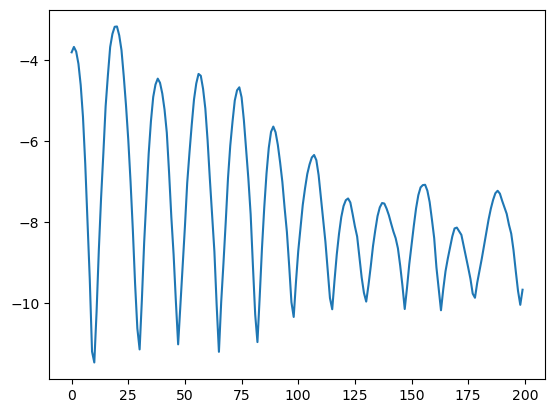

In [55]:
print(np.array(obs_rew).sum())
plt.plot(obs_rew)

## Using RL algorithms from Stable Baselines

In [ ]:
model = SAC("MlpPolicy", 
            "Pendulum-v1",
            verbose=1
            #learning_rate=3e-4,
            #batch_size=64,
            #n_steps=2048
)

model.learn(25_000)

Using cpu device
Creating environment from the given name 'Pendulum-v1'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.45e+03 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 165       |
|    time_elapsed    | 4         |
|    total_timesteps | 800       |
| train/             |           |
|    actor_loss      | 23.6      |
|    critic_loss     | 0.23      |
|    ent_coef        | 0.813     |
|    ent_coef_loss   | -0.322    |
|    learning_rate   | 0.0003    |
|    n_updates       | 699       |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.49e+03 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 157       |
|    time_e

In [78]:
vec_env = model.get_env()
obs = vec_env.reset()

obs_rew = []

done = False
while not done:
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, info = vec_env.step(action)

    obs_rew.append(reward)

env.close()

In [92]:
env = gym.make('Pendulum-v1', render_mode="human")
obs_rew = []

obs, info = env.reset()
for _ in range(200):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, terminated, truncated, info = env.step(action)
    obs_rew.append(rewards)
    if terminated or truncated:
        obs, info = env.reset()
env.close()
obs_rew = np.array(obs_rew)

-238.7347772537661


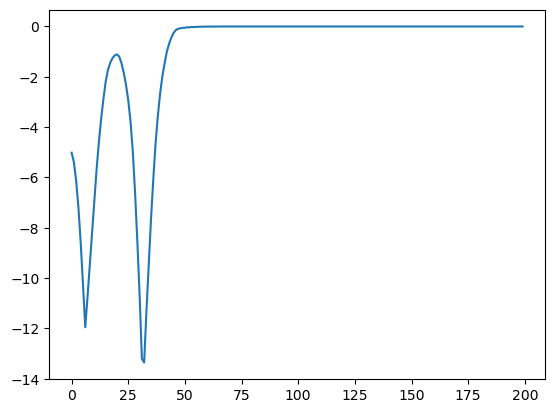

In [93]:
print(np.array(obs_rew).sum())
plt.plot(obs_rew)

## Using PD control

In [51]:
def pd_controller(observation, kp, kd):
    """
    Args:
        observation (numpy.ndarray): The current observation from the environment.
                                     For Pendulum-v1, this is [cos(theta), sin(theta), theta_dot].
        kp (float): Proportional gain.
        kd (float): Derivative gain.

    Returns:
        float: The control action (torque) to apply to the pendulum.
    """
    cos_theta, sin_theta, theta_dot = observation
    theta = np.arctan2(sin_theta, cos_theta)

    desired_theta = 0.0
    desired_theta_dot = 0.0

    error_theta = desired_theta - theta
    error_theta_dot = desired_theta_dot - theta_dot

    torque = kp * error_theta + kd * error_theta_dot    
    torque = np.clip(torque, -2.0, 2.0)  # action space for Pendulum-v1 is a Box(-2.0, 2.0, (1,), float32)

    return torque

In [52]:
theta = np.pi / 3
o = [np.cos(theta), np.sin(theta), -8.]
pd_controller(o, kp_gain, kd_gain)

np.float64(-1.235987755982988)

In [75]:
env = gym.make("Pendulum-v1", render_mode="human")

kp_gain = 20.0
kd_gain = 0.1

obs_rew = []

# Run the simulation for a number of episodes
num_episodes = 5
for episode in range(num_episodes):

    observation, info = env.reset()
    terminated = False
    truncated = False
    episode_reward = 0

    while not terminated and not truncated:
        action = pd_controller(observation, kp_gain, kd_gain)

        # The environment expects the action as a 1-element array
        observation, reward, terminated, truncated, info = env.step(np.array([action]))

        obs_rew.append(reward)

    print(f"Episode {episode + 1} finished with reward: {np.array(obs_rew).sum():.2f}")

env.close()

Episode 1 finished with reward: -1494.49
Episode 2 finished with reward: -2855.76
Episode 3 finished with reward: -4368.41
Episode 4 finished with reward: -4372.95
Episode 5 finished with reward: -5326.03


## Collecting some random trajectories

In [96]:
env = gym.make('Pendulum-v1')

n_traj = 10

trajs = []

for i in range(n_traj):
    obs = env.reset()

    traj = []
    over = False
    while not over:
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)

        traj.append(obs)
        over = terminated or truncated
    trajs.append(traj)

env.close()
trajs = np.array(trajs)

## Trajectory representation

In [97]:
trajs.shape

(10, 200, 3)

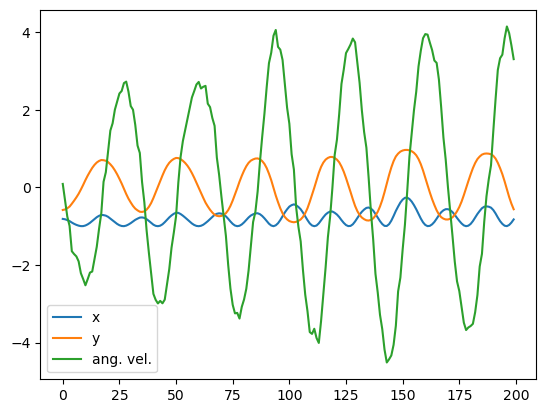

In [113]:
traj_idx = 7
plt.plot(trajs[traj_idx, :, 0], label='x')
plt.plot(trajs[traj_idx, :, 1], label='y')
plt.plot(trajs[traj_idx, :, 2], label='ang. vel.')
plt.legend()